In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import torch.nn.functional as F

import numpy as np
from skimage import data
from skimage.transform import resize

import matplotlib.pyplot as plt

import torch

from src.vqgan import ViTVQGAN

In [3]:
path = f"./checkpoint/imagenet_vitvq_base.ckpt"
sd = torch.load(path, map_location="cuda:0")["state_dict"]
keys = list(sd.keys())

In [4]:
vitvq = ViTVQGAN(
    image_size=256, patch_size=8,
    dim=768, depth=12, heads=12,
    n_codes=8192, embed_dim=32
)
vitvq.eval()
vitvq.cuda()
print()

In [5]:
# 'quantizer.embedding.weight',
#  'pre_quant.weight',
#  'pre_quant.bias',
#  'post_quant.weight',
#  'post_quant.bias']

with torch.no_grad():
	for key, item in sd.items():
		if key.startswith("quantizer"):
			vitvq.quantizer.embedding.weight.data.copy_(item)
		elif key.startswith("pre_quant"):
			if "weight" in key:
				vitvq.pre_quant.weight.data.copy_(item)
			elif "bias" in key:
				vitvq.pre_quant.bias.data.copy_(item)
		elif key.startswith("post_quant"):
			if "weight" in key:
				vitvq.post_quant.weight.data.copy_(item)
			elif "bias" in key:
				vitvq.post_quant.bias.data.copy_(item)
		elif key.startswith("encoder"):
			# Encoder
			if "transformer" in key:
				if "layers" in key:
					layer_idx = key.index("layers")
					dot_idx = key.find(".", layer_idx+len("layers")+1)
					idx = int(key[layer_idx+len("layers")+1:dot_idx])
					if "0" in key[dot_idx:]:
						if "norm" in key[dot_idx:]:
							if "weight" in key[dot_idx:]:
								vitvq.encoder.transformer[idx].attn_norm.weight.data.copy_(item)
							if "bias" in key[dot_idx:]:
								vitvq.encoder.transformer[idx].attn_norm.bias.data.copy_(item)
						if "fn" in key[dot_idx:]:
							if "to_qkv" in key[dot_idx:]:
								if "weight" in key[dot_idx:]:
									d = item.shape[1]
									vitvq.encoder.transformer[idx].attn.query.weight.copy_(item[:d])
									vitvq.encoder.transformer[idx].attn.key.weight.copy_(item[d:-d])
									vitvq.encoder.transformer[idx].attn.value.weight.copy_(item[-d:])
								if "bias" in key[dot_idx:]: pass
							if "to_out" in key[dot_idx:]:
								if "weight" in key[dot_idx:]:
									vitvq.encoder.transformer[idx].attn.proj.weight.data.copy_(item)
								if "bias" in key[dot_idx:]:
									vitvq.encoder.transformer[idx].attn.proj.bias.data.copy_(item)
					if "1" in key[dot_idx:]:
						if "norm" in key[dot_idx:]:
							if "weight" in key[dot_idx:]:
								vitvq.encoder.transformer[idx].mlp_norm.weight.copy_(item)
							if "bias" in key[dot_idx:]:
								vitvq.encoder.transformer[idx].mlp_norm.bias.copy_(item)
						if "net" in key[dot_idx:]:
							if ".net.0." in key[dot_idx:]:
								if "weight" in key[dot_idx:]:
									vitvq.encoder.transformer[idx].mlp[0].weight.copy_(item)
								if "bias" in key[dot_idx:]:
									vitvq.encoder.transformer[idx].mlp[0].bias.copy_(item)
							if ".net.2." in key[dot_idx:]:
								if "weight" in key[dot_idx:]:
									vitvq.encoder.transformer[idx].mlp[3].weight.copy_(item)
								if "bias" in key[dot_idx:]:
									vitvq.encoder.transformer[idx].mlp[3].bias.copy_(item)
				elif "encoder.transformer.norm" in key:
					if "weight" in key:
						vitvq.encoder.norm.weight.data.copy_(item)
					if "bias" in key:
						vitvq.encoder.norm.bias.data.copy_(item)
			elif "en_pos_embedding" in key:
				vitvq.encoder.en_pos_embedding.copy_(item)
			elif "to_patch_embedding" in key:
				if "weight" in key:
					vitvq.encoder.to_patch_embedding[0].weight.copy_(item)
				elif "bias" in key:
					vitvq.encoder.to_patch_embedding[0].bias.copy_(item)
		elif key.startswith("decoder"):
			if "de_pos_embedding" in key:
				vitvq.decoder.de_pos_embedding.copy_(item)
			elif "transformer" in key:
				if "layers" in key:
					layer_idx = key.index("layers")
					dot_idx = key.find(".", layer_idx+len("layers")+1)
					idx = int(key[layer_idx+len("layers")+1:dot_idx])
					if "0" in key[dot_idx:]:
						if "norm" in key[dot_idx:]:
							if "weight" in key[dot_idx:]:
								vitvq.decoder.transformer[idx].attn_norm.weight.data.copy_(item)
							if "bias" in key[dot_idx:]:
								vitvq.decoder.transformer[idx].attn_norm.bias.data.copy_(item)
						if "fn" in key[dot_idx:]:
							if "to_qkv" in key[dot_idx:]:
								if "weight" in key[dot_idx:]:
									d = item.shape[1]
									vitvq.decoder.transformer[idx].attn.query.weight.copy_(item[:d])
									vitvq.decoder.transformer[idx].attn.key.weight.copy_(item[d:-d])
									vitvq.decoder.transformer[idx].attn.value.weight.copy_(item[-d:])
								if "bias" in key[dot_idx:]: pass
							if "to_out" in key[dot_idx:]:
								if "weight" in key[dot_idx:]:
									vitvq.decoder.transformer[idx].attn.proj.weight.data.copy_(item)
								if "bias" in key[dot_idx:]:
									vitvq.decoder.transformer[idx].attn.proj.bias.data.copy_(item)
					if "1" in key[dot_idx:]:
						if "norm" in key[dot_idx:]:
							if "weight" in key[dot_idx:]:
								vitvq.decoder.transformer[idx].mlp_norm.weight.copy_(item)
							if "bias" in key[dot_idx:]:
								vitvq.decoder.transformer[idx].mlp_norm.bias.copy_(item)
						if "net" in key[dot_idx:]:
							if ".net.0." in key[dot_idx:]:
								if "weight" in key[dot_idx:]:
									vitvq.decoder.transformer[idx].mlp[0].weight.copy_(item)
								if "bias" in key[dot_idx:]:
									vitvq.decoder.transformer[idx].mlp[0].bias.copy_(item)
							if ".net.2." in key[dot_idx:]:
								if "weight" in key[dot_idx:]:
									vitvq.decoder.transformer[idx].mlp[3].weight.copy_(item)
								if "bias" in key[dot_idx:]:
									vitvq.decoder.transformer[idx].mlp[3].bias.copy_(item)
				elif "decoder.transformer.norm" in key:
					if "weight" in key:
						vitvq.decoder.norm.weight.data.copy_(item)
					if "bias" in key:
						vitvq.decoder.norm.bias.data.copy_(item)
			elif "to_pixel" in key:
				if "weight" in key:
					vitvq.decoder.to_pixel[1].weight.copy_(item)
				if "bias" in key:
					vitvq.decoder.to_pixel[1].bias.copy_(item)
			else:
				print(key)
				



In [6]:
vitvq.init_from_ckpt(path)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image = data.coffee()
image_resized = resize(image, (256, 256), anti_aliasing=True)
input_data = (
	torch.tensor(image_resized).permute(2, 0, 1).unsqueeze(0).float().to(device)
)
image.shape, image_resized.shape, input_data.shape

((400, 600, 3), (256, 256, 3), torch.Size([1, 3, 256, 256]))

In [9]:
with torch.no_grad():
	# encoding
	quant, diff = vitvq.encode(input_data)
	# decoding
	output = vitvq.decode(quant)
	output_image = output.squeeze(0).permute(1, 2, 0).cpu().numpy()
output_image = output_image.clip(0, 1)

print(quant.shape, output_image.shape)

torch.Size([1, 1024, 32]) (256, 256, 3)


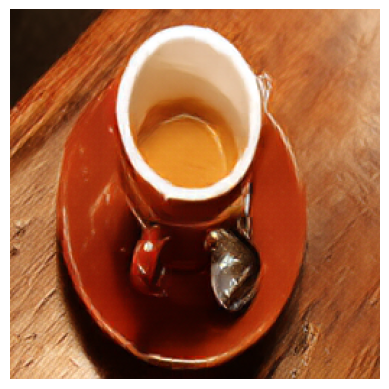

In [10]:
plt.imshow(output_image)
plt.axis("off")
plt.show()

In [11]:
with torch.no_grad():
	# encoding
	code = vitvq.encode_codes(input_data)

code.shape

torch.Size([1, 1024])

In [ ]:
length, height, width, dim = 12, 4, 4, 8

t_emb = nn.Parameter(torch.empty(1, length, dim).normal_(std=0.02))
h_emb = nn.Parameter(torch.empty(1, height, dim).normal_(std=0.02))
w_emb = nn.Parameter(torch.empty(1, width, dim).normal_(std=0.02))

t_emb.shape, h_emb.shape, w_emb.shape

In [ ]:
type(t_emb.device)

In [ ]:
torch.triu(torch.ones(4, 4), diagonal=1).unsqueeze(0).shape